In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import LinAlgError
from scipy.stats import skew, kurtosis
from PIL import Image
Image.LOAD_TRUNCATED_IMAGES = True
import sys, os
import logging
import argparse, copy
import time
import sutils
import steerable_pyramid_mat as steerable
import texture_analysis_g as ta
import scipy.io
from pandas import DataFrame as df
import pandas as pd
logger = logging.getLogger()
logger.setLevel(level=50)

# memo

- parents 達はなぜ2倍位相にするのか これは学びたい

In [4]:
class my_arg:
    def __init__(self):
        #self.orig_img = "periodic/CountExamp1.o.jpg"
        #self.orig_img = "bark.jpg"      
        #self.orig_img="laby-05.jpg"
        self.orig_img="image/sea-island/sea_02.jpg"
        self.out_dir = "tmp"
        self.num_depth = 4
        self.num_ori = 4
        self.num_neighbor = 7
        self.iter = 100
args = my_arg()

arg = my_arg()
iter = arg.iter
orig_img = arg.orig_img
out_dir  = arg.out_dir
num_depth= arg.num_depth
num_ori  = arg.num_ori
num_neighbor = arg.num_neighbor

im = np.array(Image.open(args.orig_img).convert("L"))

resol_x = im.shape[1]
resol_y = im.shape[0]

__file__ = "aa"
LOG_FMT = "[%(name)s] %(asctime)s %(levelname)s %(lineno)s %(message)s"
logging.basicConfig(level=logging.DEBUG, format=LOG_FMT)
LOGGER = logging.getLogger(os.path.basename(__file__))

In [5]:
mat_data = scipy.io.loadmat("matlab/counter_not_noise.mat")

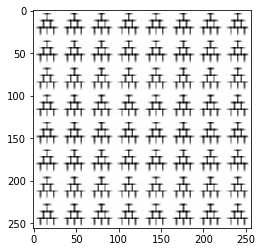

In [6]:
plt.imshow(mat_data["im0"],"gray")

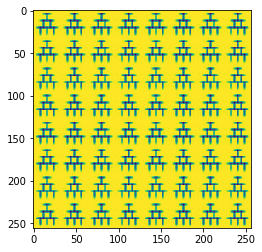

In [214]:
plt.imshow(mat_data["im0"])

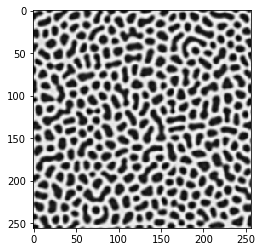

In [7]:
plt.imshow(im,"gray")

In [8]:
params = mat_data["params"]
params = params[0][0]

In [9]:
orig_data = ta.TextureAnalysis(im, resol_x, resol_y, arg.num_depth, arg.num_ori, arg.num_neighbor)
orig_data.analyse()

In [10]:
N = 4
K = 4
M = 7

In [11]:
params.dtype

dtype([('pixelStats', 'O'), ('pixelLPStats', 'O'), ('autoCorrReal', 'O'), ('autoCorrMag', 'O'), ('magMeans', 'O'), ('cousinMagCorr', 'O'), ('parentMagCorr', 'O'), ('cousinRealCorr', 'O'), ('parentRealCorr', 'O'), ('varianceHPR', 'O')])

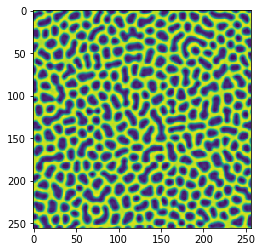

In [12]:
plt.imshow(im)

In [39]:
param_count = np.zeros([10])

# 0. pixelStats IM_MAR
$6$

 元画像輝度のmean,variance,skew,kurtosis,minimum,maximum 
 
- 等しい
- 互いに6次元

In [40]:
param_count[0] = 6
param_count #何次元か見よう

array([6., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [191]:
a=df(orig_data.IM_MAR)
a

,0
0,125.383743
1,15781.558316
2,0.033845
3,1.002732
4,255.000000
5,0.000000


In [171]:
df(orig_data)

ValueError: DataFrame constructor not properly called!

In [189]:
df(params[0])

,0,1,2,3,4,5
0,222.196289,3525.883435,-1.878269,5.57467,0.0,255.0


In [193]:
df(params[1])

,0,1
0,-1.788675,5.196226
1,-1.183097,3.371317
2,-0.588446,1.852543
3,-0.378953,2.621126
4,0.000000,3.000000


In [157]:
df(orig_data.IM_MAR).T

,0,1,2,3,4,5
0,125.383743,15781.558316,0.033845,1.002732,255.0,0.0


# 1 pixelLPStats LR_MARとCF_MAR

$2(N+1)$

- 部分的に再構成されたローパス画像の歪度と尖度
- params[N+1][2]
- CF_MAR[N][2:4] + LR_MAR[2:4]

In [212]:
param_count[1] = 2 * (N+1)

In [154]:
df(params[1])

,0,1
0,-1.788675,5.196226
1,-1.183097,3.371317
2,-0.588446,1.852543
3,-0.378953,2.621126
4,0.000000,3.000000


In [14]:
df(params[1]).T

,0,1,2,3,4
0,-1.788675,-1.183097,-0.588446,-0.378953,0.0
1,5.196226,3.371317,1.852543,2.621126,3.0


In [106]:
df(np.array(orig_data.CF_MAR)[2:4]).T

,0,1
0,1.776357e-15,0.000000
1,9.166787e+05,340927.239091
2,-4.983245e-01,-0.235042
3,2.456946e+00,3.623831
4,2.273332e+03,1830.539829
5,-2.704724e+03,-2692.136875


In [111]:
np.array(orig_data.CF_MAR)[:,2:4]

array([[-0.24820909,  1.47597612],
       [-0.28732091,  1.64383529],
       [-0.49832453,  2.4569462 ],
       [-0.23504241,  3.62383115]])

In [120]:
cfmar=np.array(orig_data.CF_MAR)[:,2:4]
df(np.array(orig_data.CF_MAR)[:,2:4])


,0,1
0,-0.248209,1.475976
1,-0.287321,1.643835
2,-0.498325,2.456946
3,-0.235042,3.623831


In [117]:
lrmar=np.array(orig_data.LR_MAR)[2:4]
df(np.array(orig_data.LR_MAR)[2:4]).T

,0
0,-0.236611
1,2.791078


In [122]:
C1=np.vstack((cfmar,lrmar))  
df(C1)

,0,1
0,-0.248209,1.475976
1,-0.287321,1.643835
2,-0.498325,2.456946
3,-0.235042,3.623831
4,-0.236611,2.791078


# 2 autoCorrReal  CF_CA and LR_CA
$(N+1) * \frac{(M^2+1)}{2}$

各スケールで部分的に再構成されたローパス画像の自己相関のM*M

- params[2] = [M,M,N+1] 
- CF_CF[N,M,M] + LR_CA[M,M]

In [17]:
param_count[2] = (N+1) * (M**2 + 1)/2

In [18]:
print(params[2].shape)

(7, 7, 5)


In [17]:
df(params[2][:,:,4]) # 4 = LR_CA

,0,1,2,3,4,5,6
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [198]:
df(orig_data.CF_CA[1])

,0,1,2,3,4,5,6
0,-63899.832829,-68255.017725,-50929.121671,-34416.614279,-35933.799682,-49942.923266,-56370.691787
1,-62188.094051,-29129.547716,24246.411902,54288.717978,34484.355408,-17509.519284,-59390.816752
2,-46168.650250,25223.953319,114454.241015,157668.345531,119479.499310,30569.301704,-45724.113700
3,-37163.189996,52239.522481,157004.265278,204590.934859,157004.265278,52239.522481,-37163.189996
4,-45724.113700,30569.301704,119479.499310,157668.345531,114454.241015,25223.953319,-46168.650250
5,-59390.816752,-17509.519284,34484.355408,54288.717978,24246.411902,-29129.547716,-62188.094051
6,-56370.691787,-49942.923266,-35933.799682,-34416.614279,-50929.121671,-68255.017725,-63899.832829


In [156]:
df(orig_data.CF_CA[1])

,0,1,2,3,4,5,6
0,-63899.832829,-68255.017725,-50929.121671,-34416.614279,-35933.799682,-49942.923266,-56370.691787
1,-62188.094051,-29129.547716,24246.411902,54288.717978,34484.355408,-17509.519284,-59390.816752
2,-46168.650250,25223.953319,114454.241015,157668.345531,119479.499310,30569.301704,-45724.113700
3,-37163.189996,52239.522481,157004.265278,204590.934859,157004.265278,52239.522481,-37163.189996
4,-45724.113700,30569.301704,119479.499310,157668.345531,114454.241015,25223.953319,-46168.650250
5,-59390.816752,-17509.519284,34484.355408,54288.717978,24246.411902,-29129.547716,-62188.094051
6,-56370.691787,-49942.923266,-35933.799682,-34416.614279,-50929.121671,-68255.017725,-63899.832829


In [41]:
df(orig_data.LR_CA)

,0,1,2,3,4,5,6
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
a = copy.copy(orig_data.LR["s"])

In [23]:
a = a - a.mean()

In [24]:
np.dot(a.flatten(),a.flatten())/256

6.309180055109966

# 3.autoCorrMag  BND_MCOR

$N*K*\frac{M^2 + 1}{2}$

- 各サブバンドの画像の絶対値の自己相関の中央サンプルM*M
- pythonとちがう
- params[3] = [M,M,N,K]
- BND_MCOR[N,K,M,M]

In [22]:
param_count[3] =  N * K * (M**2 + 1)/2

In [23]:
params[3].shape

(7, 7, 4, 4)

In [36]:
df(params[3][:,:,3,3])

,0,1,2,3,4,5,6
0,-73227.818255,-22673.392442,73490.827326,21873.307536,-73227.818255,-22673.392442,73490.827326
1,-58590.259804,-13493.292950,-58590.259804,-108013.223438,-58590.259804,-13493.292950,-58590.259804
2,73490.827326,-22673.392442,-73227.818255,21873.307536,73490.827326,-22673.392442,-73227.818255
3,57859.227677,-43113.416297,57859.227677,167156.148610,57859.227677,-43113.416297,57859.227677
4,-73227.818255,-22673.392442,73490.827326,21873.307536,-73227.818255,-22673.392442,73490.827326
5,-58590.259804,-13493.292950,-58590.259804,-108013.223438,-58590.259804,-13493.292950,-58590.259804
6,73490.827326,-22673.392442,-73227.818255,21873.307536,73490.827326,-22673.392442,-73227.818255


In [25]:
df(orig_data.BND_MCOR[0][3])

,0,1,2,3,4,5,6
0,32.275510,46.987519,55.479584,48.350316,45.058760,52.647792,54.017337
1,44.306377,54.969662,49.968426,49.786908,62.913680,67.311390,49.744653
2,51.482141,48.583728,50.652037,69.022746,78.797208,60.371556,40.788573
3,44.255469,47.265978,67.947749,83.593219,67.947749,47.265978,44.255469
4,40.788573,60.371556,78.797208,69.022746,50.652037,48.583728,51.482141
5,49.744653,67.311390,62.913680,49.786908,49.968426,54.969662,44.306377
6,54.017337,52.647792,45.058760,48.350316,55.479584,46.987519,32.275510


# 4.magMeans BND_MMAR

$N*K$

- 各スケール，各サブバンドにおける絶対値の平均値
- 絶対値がらみはpythonと違うっぽい

- params[4] = [18,1] L0 と H0が含まれているため

- BND_MMAR[N,K][6] [0]を抜き出すことになる 

In [41]:
param_count[4] = N * K

In [42]:
params[4].shape #H0 とL0 が含まれているため． 16 + 2

(18, 1)

In [43]:
df(params[4])

,0
0,4.435796
1,15.905867
2,10.578279
3,17.216369
4,10.506390
5,75.203904
6,70.016965
7,99.547751
8,70.080087
9,205.689338


In [28]:
df(params[4].reshape(1,-1))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,4.441547,15.905799,10.578581,17.216618,10.508453,75.208884,70.013402,99.545267,70.082209,205.71842,201.275729,190.67966,202.396425,1939.865756,900.668615,1499.93915,901.678233,2.08845


In [29]:
df(np.array(orig_data.BND_MMAR)[:,:,0].flatten()).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,15.906233,10.579872,17.21807,10.507984,75.204111,70.014702,99.547857,70.076099,205.686098,201.25349,190.681158,202.378537,1940.051298,900.693287,1499.853544,901.720137


In [30]:
params[4].reshape(-1)[1:17] - np.array(orig_data.BND_MMAR)[:,:,0].flatten()

array([-0.00043483, -0.00129133, -0.00145182,  0.00046858,  0.00477368,
       -0.00130001, -0.00259035,  0.00610971,  0.03232194,  0.02223933,
       -0.00149835,  0.01788783, -0.18554232, -0.02467171,  0.08560562,
       -0.04190452])

# 5.Cousin mag corr  　 CF_COUS
$ N * \frac{K*(K-1)}{2}$

各スケールにおける，各サブバンド対の絶対値の相互相関

- params[5] = [K,K,(N+1)]
  - params[5][:,:,4] は0であることに注意
  
- CF_COUS[N,K,K]
- 値はpythonのものとやっぱり違いそう

- CF_COUS[]

In [44]:
param_count[5] = N*(K*(K-1))/2

In [45]:
params[5].shape

(4, 4, 5)

In [56]:
df(params[5][:,:,0])

,0,1,2,3
0,291.146634,113.470724,155.303083,114.911218
1,113.470724,82.860927,113.191491,62.190996
2,155.303083,113.191491,256.873193,114.427254
3,114.911218,62.190996,114.427254,83.593219


In [46]:
df(orig_data.CF_COUS[0])

,0,1,2,3
0,35.023596,10.607431,-3.952853,11.654989
1,10.607431,19.854139,13.169460,5.084859
2,-3.952853,13.169460,38.468501,12.648990
3,11.654989,5.084859,12.648990,19.855708


# 6 Parent mag corr CF_CPAR 
$ K^2 (N-1)$

各スケールのサブバンドとより粗いスケールのサブバンドの絶対値の相互相関 

- params[6] = [4,4,4]
  - params[6][:,:,3] は0であることに注意する．(だからk×k×"(N-1)")
  
- CF_CPAR[N-1,K,K]


In [98]:
print(N)
print(K)

4
4


In [57]:
param_count[6] = K*K*(N-1)

In [58]:
print(params[6].shape)

(4, 4, 4)


In [66]:
df(params[6][:,:,0])

,0,1,2,3
0,230.698864,132.166117,250.599169,133.453404
1,88.965625,86.015743,152.976511,85.064158
2,108.101176,178.015111,317.224644,180.898188
3,88.312365,84.960863,154.351582,88.248952


In [37]:
params[6][:,:,2] 

array([[ -255.28144269,  -693.78201858,   365.79206368,  -667.8428384 ],
       [ -917.39776878,   366.49453824,   685.1201131 , -3839.98288069],
       [ -415.30316037,   438.92788783,  1858.95282783,   385.9191696 ],
       [ -933.5019696 , -3807.6488457 ,   799.50019379,   398.07434534]])

In [38]:
orig_data.CF_CPAR

[array([[230.70083511, 132.16035401, 250.59052016, 133.45592728],
        [ 88.96197028,  85.98739825, 152.93817847,  85.05082173],
        [108.08851437, 177.99297034, 317.24137977, 180.91347048],
        [ 88.29622213,  84.95075898, 154.34568223,  88.251971  ]]),
 array([[280.29208337, 297.53961191, 870.11345031, 295.40499494],
        [167.20918315,  54.66687291, 595.38588251, 279.10181324],
        [284.54087715, 178.670249  , 560.20454763, 204.51434772],
        [168.64018281, 262.13137005, 608.92823211,  60.3735673 ]]),
 array([[ -255.07403523,  -692.70291998,   365.70851581,  -667.12679867],
        [ -917.58928117,   365.37916821,   686.56669263, -3837.68292394],
        [ -414.30287642,   439.7361832 ,  1861.01819503,   390.94490129],
        [ -935.29717414, -3809.04921294,   798.60824019,   394.53177439]])]

# 7 Cousin real corr CF_RCOU
$ N \frac{K(K-1)}{2}$

各スケールにおける，各サブバンド対の実数の相互相関

- params[7] = [8,8,5]
  - 8 * 8の行列であるが，4 * 4しか使っていないことに注意
  - 配列が5個あるのが謎である．．最下層のスケールにバンドでもあんの？？
 
- CF_RCOU[N,K,K]

In [67]:
param_count[7] = N*(K*(K-1))/2

In [68]:
params[7].shape

(8, 8, 5)

In [74]:
df(params[7][:,:,4])

,0,1,2,3,4,5,6,7
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
df(params[7][:,:,1])

,0,1,2,3,4,5,6,7
0,5111.592060,2670.658866,-1.883743,-2702.105321,0.0,0.0,0.0,0.0
1,2670.658866,4069.026793,3534.701210,600.994765,0.0,0.0,0.0,0.0
2,-1.883743,3534.701210,8715.050679,3534.368210,0.0,0.0,0.0,0.0
3,-2702.105321,600.994765,3534.368210,4098.562139,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
5,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
6,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
7,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0


In [102]:
df(params[7][:,:,4])

,0,1,2,3,4,5,6,7
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
orig_data.CF_RCOU[1]

array([[ 5.11152982e+03,  2.67039184e+03, -1.91301162e+00,
        -2.70214985e+03],
       [ 2.67039184e+03,  4.06857953e+03,  3.53458426e+03,
         6.00961437e+02],
       [-1.91301162e+00,  3.53458426e+03,  8.71481467e+03,
         3.53420544e+03],
       [-2.70214985e+03,  6.00961437e+02,  3.53420544e+03,
         4.09841986e+03]])

# 8. parent real corr CF_RPAR
$2*K^2 (N-1)$

 クロススケール位相特性
 各スケールの実数成分と．1つ粗いスケールで位相を二倍した実数及び虚数との相互相関

- params[8] = [2K,2K,(N)]
 - なぜ4まであるか謎である．
 - (8*8)であるが実際は(4,8)しか使ってない．
 
- CF_RPAR[N-1,K,2K]

In [75]:
param_count[8] = 2*K*K*(N-1)

In [76]:
print(params[8].shape)

(8, 8, 4)


In [79]:
complex(1,1)

(1+1j)

In [84]:
df(params[8][:,:,3])

,0,1,2,3,4,5,6,7
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
df(params[8][:,:,0])

,0,1,2,3,4,5,6,7
0,-0.274169,-12.740980,0.033659,13.376169,-236.682681,-36.909000,0.043019,36.421500
1,1.964587,-1.388622,15.581706,7.221945,-86.342237,-54.504708,-121.444222,-0.585473
2,-0.109025,12.742947,38.682365,11.703133,-0.142504,-48.797796,-331.212404,-49.079467
3,2.135205,7.012995,14.898269,-3.043267,84.913992,-0.727937,-120.974464,-55.701965
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [104]:
df(params[8][:,:,3])

,0,1,2,3,4,5,6,7
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [205]:
df(orig_data.CF_RPAR[0])

,0,1,2,3,4,5,6,7
0,2.305838,4.211626,-0.465431,1.023409,6.528208,3.563802,0.120226,-1.666909
1,3.394071,0.052722,-2.108293,0.093696,4.709058,0.238000,3.409641,-0.482498
2,0.849657,-2.507794,-1.876144,-1.848674,-0.116666,1.029924,1.797830,-1.232055
3,0.519854,0.284088,0.224070,-2.524632,-3.212735,0.141050,2.599781,-0.482368


In [47]:
df(orig_data.CF_RPAR[0])

,0,1,2,3,4,5,6,7
0,-0.279413,-12.743050,0.033114,13.382287,-236.684696,-36.918687,0.043763,36.421820
1,1.959431,-1.397172,15.590301,7.222181,-86.347459,-54.497611,-121.453854,-0.586351
2,-0.110661,12.741273,38.705585,11.697919,-0.143422,-48.794324,-331.249658,-49.093549
3,2.134928,7.012429,14.905339,-3.060979,84.908520,-0.727379,-120.991871,-55.716491


# 9.variance HPR  orig_data.H0_PRO
$1$

h0の分散．
- 一緒っぽい

In [85]:
param_count[9] = 1

In [88]:
df(params[9])

,0
0,41.85842


In [89]:
orig_data.H0_PRO

24.65669148477151

In [90]:
orig_data.H0_PRO

24.65669148477151

In [94]:
#params[1].to_csv("test.csv")
#N=4
#K=4
#M=7
#for i in range(N+1):
    #np.savetxt('out2/out2_+str(i)+.csv',params[2][:,:,1],delimiter=',')
#np.savetxt('out/out1/out1_1枚目.csv',params[1],delimiter=',')
np.savetxt('out/out1/out1_1枚目.csv',df(orig_data.IM_MAR),delimiter=',')
    
np.savetxt('out/out2/out2_1枚目_N+1=1.csv',params[2][:,:,1],delimiter=',')
np.savetxt('out/out2/out2_1枚目_N+1=2.csv',params[2][:,:,2],delimiter=',')
np.savetxt('out/out2/out2_1枚目_N+1=3.csv',params[2][:,:,3],delimiter=',')
np.savetxt('out/out2/out2_1枚目_N+1=4.csv',params[2][:,:,4],delimiter=',')
np.savetxt('out/out2/out2_1枚目_N+1=0.csv',params[2][:,:,0],delimiter=',')

np.savetxt('out/out3/out3_1枚目_N=0,K=0.csv',params[3][:,:,0,0],delimiter=',')
np.savetxt('out/out3/out3_1枚目_N=0,K=1.csv',params[3][:,:,0,1],delimiter=',')
np.savetxt('out/out3/out3_1枚目_N=0,K=2.csv',params[3][:,:,0,2],delimiter=',')
np.savetxt('out/out3/out3_1枚目_N=0,K=3.csv',params[3][:,:,0,3],delimiter=',')
np.savetxt('out/out3/out3_1枚目_N=1,K=0.csv',params[3][:,:,1,0],delimiter=',')
np.savetxt('out/out3/out3_1枚目_N=1,K=1.csv',params[3][:,:,1,1],delimiter=',')
np.savetxt('out/out3/out3_1枚目_N=1,K=2.csv',params[3][:,:,1,2],delimiter=',')
np.savetxt('out/out3/out3_1枚目_N=1,K=3.csv',params[3][:,:,1,3],delimiter=',')
np.savetxt('out/out3/out3_1枚目_N=2,K=0.csv',params[3][:,:,2,0],delimiter=',')
np.savetxt('out/out3/out3_1枚目_N=2,K=1.csv',params[3][:,:,2,1],delimiter=',')
np.savetxt('out/out3/out3_1枚目_N=2,K=2.csv',params[3][:,:,2,2],delimiter=',')
np.savetxt('out/out3/out3_1枚目_N=2,K=3.csv',params[3][:,:,2,3],delimiter=',')
np.savetxt('out/out3/out3_1枚目_N=3,K=0.csv',params[3][:,:,3,0],delimiter=',')
np.savetxt('out/out3/out3_1枚目_N=3,K=1.csv',params[3][:,:,3,1],delimiter=',')
np.savetxt('out/out3/out3_1枚目_N=3,K=2.csv',params[3][:,:,3,2],delimiter=',')
np.savetxt('out/out3/out3_1枚目_N=3,K=3.csv',params[3][:,:,3,3],delimiter=',')

np.savetxt('out/out4/out4_1枚目.csv',params[4],delimiter=',')

np.savetxt('out/out5/out5_1枚目_N+1=0.csv',params[5][:,:,0],delimiter=',')
np.savetxt('out/out5/out5_1枚目_N+1=1.csv',params[5][:,:,1],delimiter=',')
np.savetxt('out/out5/out5_1枚目_N+1=2.csv',params[5][:,:,2],delimiter=',')
np.savetxt('out/out5/out5_1枚目_N+1=3.csv',params[5][:,:,3],delimiter=',')
np.savetxt('out/out5/out5_1枚目_N+1=4.csv',params[5][:,:,4],delimiter=',')

np.savetxt('out/out6/out6_1枚目_N=1.csv',params[6][:,:,0],delimiter=',')
np.savetxt('out/out6/out6_1枚目_N=2.csv',params[6][:,:,1],delimiter=',')
np.savetxt('out/out6/out6_1枚目_N=3.csv',params[6][:,:,2],delimiter=',')
np.savetxt('out/out6/out6_1枚目_N=4.csv',params[6][:,:,3],delimiter=',')

np.savetxt('out/out7/out7_1枚目_.csv',params[7][:,:,0],delimiter=',')
np.savetxt('out/out7/out7_1枚目_.csv',params[7][:,:,1],delimiter=',')
np.savetxt('out/out7/out7_1枚目_.csv',params[7][:,:,2],delimiter=',')
np.savetxt('out/out7/out7_1枚目_.csv',params[7][:,:,3],delimiter=',')

np.savetxt('out/out8/out8_1枚目_N=0.csv',params[8][:,:,0],delimiter=',')
np.savetxt('out/out8/out8_1枚目_N=1.csv',params[8][:,:,1],delimiter=',')
np.savetxt('out/out8/out8_1枚目_N=2.csv',params[8][:,:,2],delimiter=',')
np.savetxt('out/out8/out8_1枚目_N=3.csv',params[8][:,:,3],delimiter=',')

np.savetxt('out/out9/out9_1枚目.csv',params[9],delimiter=',')